In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [50]:
import numpy as np
import pandas as pd
from kcsd import KCSD1D

In [51]:
from sglxarray import load_trigger
from ecephys.plot import lfp_explorer, colormesh_timeseries_explorer
from ecephys.signal.utils import mean_subtract, median_subtract
from ecephys.xrsig import get_kcsd
import ecephys_analyses as ea

In [52]:
def mm_to_mask(lo, hi, ele_pos):
    assert lo < hi, "Lower bound must be less than upper bound."     
    return np.logical_and(ele_pos >= lo, ele_pos <= hi).flatten()

def mm_to_idx(lo, hi, ele_pos):
    idx = np.where(millimeters_to_mask(lo, hi, ele_pos))[0]
    return idx

def mm_to_chans(lo, hi, ele_pos, chans):
    return chans[mm_to_mask(lo, hi, ele_pos)]

In [8]:
SUBJECT = "Segundo"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 1680 # pick a 1 second window that has SPW-Rs

In [31]:
SUBJECT = "Segundo"
EXPERIMENT = "isoflurane"
CONDITION = "all"
START_TIME = 2 # pick a 1 second window that has SPW-Rs

In [9]:
SUBJECT = "Valentino"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 3880 # pick a 1 second window that has SPW-Rs

In [10]:
SUBJECT = "Valentino"
EXPERIMENT = "sevo-dex"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 355 # pick a 1 second window that has SPW-Rs

In [19]:
# During Dex-induced theta, in 2-25-2020_g0_t1

SUBJECT = "Valentino"
EXPERIMENT = "sevo-dex"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 2986 # pick a 1 second window that has SPW-Rs

In [10]:
SUBJECT = "Valentino"
EXPERIMENT = "atropine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 828 # pick a 1 second window that has SPW-Rs

In [15]:
SUBJECT = "Valentino"
EXPERIMENT = "isoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 83 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 6.1
wm_center = 6.12
wm_thickness = 0.133

In [66]:
SUBJECT = "Valentino"
EXPERIMENT = "sevoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 77 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.866
hpc_hi = 6.166
wm_center = 6.36
wm_thickness = 0.133

In [97]:
SUBJECT = "Valentino"
EXPERIMENT = "ketamine-90mg"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 16 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.856
hpc_hi = 6.156
wm_center = 6.28
wm_thickness = 0.133

In [48]:
SUBJECT = "Doppio"
EXPERIMENT = "isoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 77 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 5.8
wm_center = 5.9
wm_thickness = 0.133

In [77]:
SUBJECT = "Doppio"
EXPERIMENT = "sevoflurane"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 202 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.8
hpc_hi = 6.0
wm_center = 5.94
wm_thickness = 0.133

In [8]:
SUBJECT = "Doppio"
EXPERIMENT = "atropine-50mg"
CONDITION = "all"
START_TIME = 1159 # pick a 1 second window that has SPW-Rs

In [39]:
SUBJECT = "Doppio"
EXPERIMENT = "ketamine-120mg"
CONDITION = "all"
PROBE = "imec1"
START_TIME = 14 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.3
hpc_hi = 5.066
wm_center = 5.2
wm_thickness = 0.133

In [189]:
SUBJECT = "Alessandro"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 1766 # pick a 1 second window that has SPW-Rs

In [158]:
SUBJECT = "Alessandro"
EXPERIMENT = "dexmedetomidine-eStim"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 2008 # pick a 1 second window that has SPW-Rs

hpc_lo = 4.0
hpc_hi = 6.05
wm_center = 6.15
wm_thickness = 0.1

In [215]:
SUBJECT = "Eugene"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 2600 # pick a 1 second window that has SPW-Rs

In [239]:
SUBJECT = "Allan"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 2007 # pick a 1 second window that has SPW-Rs

In [7]:
SUBJECT = "Allan"
EXPERIMENT = "dexmedetomidine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 3 # pick a 1 second window that has SPW-Rs

In [8]:
SUBJECT = "Allan"
EXPERIMENT = "atropine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 35 # pick a 1 second window that has SPW-Rs

In [106]:
SUBJECT = "Allan"
EXPERIMENT = "ketamine"
CONDITION = "all"
PROBE = "imec0"
START_TIME = 1791 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.2
hpc_hi = 5.4
wm_center = 5.48
wm_thickness = 0.133

In [62]:
SUBJECT = "Luigi"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
PROBE = "imec0"
START_TIME = 410 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.5
hpc_hi = 5.6
wm_center = 5.7
wm_thickness = 0.133

In [95]:
SUBJECT = "Luigi"
EXPERIMENT = "dexmedetomidine"
CONDITION = "baseline"
PROBE = "imec0"
START_TIME = 2 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.55
hpc_hi = 5.25
wm_center = 5.35
wm_thickness = 0.1

In [60]:
SUBJECT = "Charles"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
PROBE = "imec1"
START_TIME = 1185 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.95
hpc_hi = 5.8
wm_center = 5.9
wm_thickness = 0.1

In [41]:
SUBJECT = "Charles"
EXPERIMENT = "dexmedetomidine"
CONDITION = "baseline"
PROBE = "imec1"
START_TIME = 14 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.7
hpc_hi = 5.6
wm_center = 5.72
wm_thickness = 0.1

In [165]:
SUBJECT = "Doppio"
EXPERIMENT = "sleep-homeostasis"
CONDITION = "recovery-sleep"
START_TIME = 1708 # pick a 1 second window that has SPW-Rs

hpc_lo = 3.3
hpc_hi = 5.066
wm_center = 5.2
wm_thickness = 0.133

## 1D kCSD on whole probe

In [166]:
chans = ea.get_channels(SUBJECT, EXPERIMENT, PROBE, "all")
bin_path = ea.get_sglx_style_datapaths(subject=SUBJECT, experiment=EXPERIMENT, condition=CONDITION, ext="lf.bin")[0]
sig = load_trigger(bin_path, chans, start_time=(START_TIME), end_time=(START_TIME + 1.0))
sig.values = mean_subtract(sig.values)

OSError: [Errno 112] Host is down: '/Volumes/neuropixel_archive/Data/chronic/CNPIX4-Doppio/3-17-2020/3-18-2020_g0/3-18-2020_g0_imec0/3-18-2020_g0_t3.imec0.lf.meta'

In [ ]:
electrode_pitch = 0.020
ele_pos = np.arange(0, len(sig.channel)) * electrode_pitch
csd = get_kcsd(
    sig, ele_pos, gdx=electrode_pitch, do_lcurve=True
)

In [167]:
print(f"Hippocampus: {hpc_lo}mm, {hpc_hi}mm")
hpc_chans = csd.sel(pos=slice(hpc_lo, hpc_hi)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:\n {hpc_chans}")
print("")

wm_lo = wm_center - wm_thickness
wm_hi = wm_center + wm_thickness
print(f"White matter: {wm_lo}mm, {wm_hi}mm")
wm_chans = csd.sel(pos=slice(wm_lo, wm_hi)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:\n {wm_chans}")

Hippocampus: 3.3mm, 5.066mm
Channels:
 [330 332 334 336 338 340 342 344 346 348 350 352 354 356 358 360 362 364
 366 368 370 372 374 376 378 380 382   1   3   5   7   9  11  13  15  17
  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53
  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89
  91  93  95  97  99 101 103 105 107 109 111 113 115 117 119 121 123]

White matter: 5.067mm, 5.333mm
Channels:
 [125 127 129 131 133 135 137 139 141 143 145 147 149]


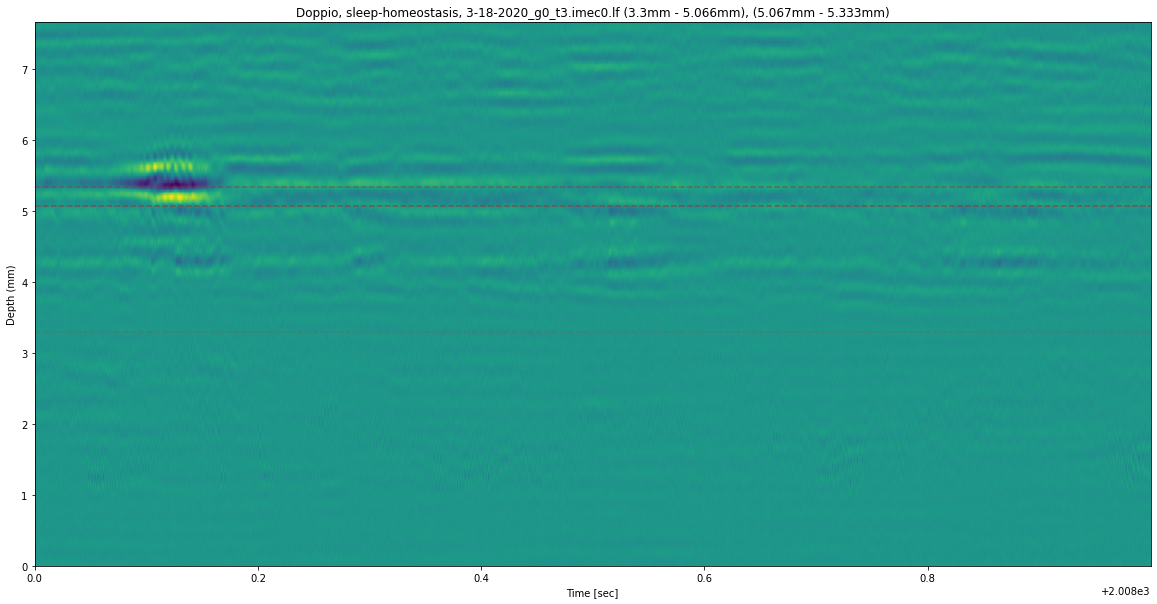

In [168]:
_, ax = plt.subplots(figsize=(20, 10))
ax.pcolormesh(csd.time.values, csd.kcsd.estm_x, csd.values, shading="gouraud")
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Depth (mm)")
ax.set_title(f"{SUBJECT}, {EXPERIMENT}, {bin_path.stem} ({hpc_lo}mm - {hpc_hi}mm), ({wm_lo}mm - {wm_hi}mm)")
ax.axhline(hpc_hi, alpha=0.5, color='dimgrey', linestyle="--")
ax.axhline(hpc_lo, alpha=0.5, color='dimgrey', linestyle="--")
ax.axhline(wm_hi, alpha=0.5, color='brown', linestyle="--")
ax.axhline(wm_lo, alpha=0.5, color='brown', linestyle="--")

In [169]:
hpc_chans

array([330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354,
       356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380,
       382,   1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,
        25,  27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,
        51,  53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,
        77,  79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101,
       103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123])

In [170]:
print(f"Drift tracking: {hpc_lo - 0.1}mm, {hpc_hi + 0.1}mm")
tracking_chans = csd.sel(pos=slice(hpc_lo - 0.1, hpc_hi + 0.1)).channel.values # These are the channel numbers belonging to the hippocampus
print(f"Channels:")
tracking_chans

Drift tracking: 3.1999999999999997mm, 5.1659999999999995mm
Channels:


array([320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344,
       346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370,
       372, 374, 376, 378, 380, 382,   1,   3,   5,   7,   9,  11,  13,
        15,  17,  19,  21,  23,  25,  27,  29,  31,  33,  35,  37,  39,
        41,  43,  45,  47,  49,  51,  53,  55,  57,  59,  61,  63,  65,
        67,  69,  71,  73,  75,  77,  79,  81,  83,  85,  87,  89,  91,
        93,  95,  97,  99, 101, 103, 105, 107, 109, 111, 113, 115, 117,
       119, 121, 123, 125, 127, 129, 131, 133])